# Part 1: Gradient Descent

In [13]:
import importlib

import numpy as np # linear algebra
import pandas as pd #dataframe library
import sklearn # machine learning library
assert sklearn.__version__ >= '0.2'
from sklearn import datasets
import random
np.random.seed(seed=42) # to have same results each time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import useful_functions
importlib.reload(useful_functions)
from useful_functions import generate_dataset, unison_shuffled_copies, get_train_test_datasets, gradient_descent
from useful_functions import plot_convergence_rate, plot_evolution_on_test_error, plot_evolution_on_test_error_with_bias


### Question 1: Load an original dataset, comment on this dataset (what are the features, the dimensions of the problem, how does the correlation matrix looks like)

First we import the dataset "California housing" retrieved from Scikit-learn, and take a brief look at the data before separating in two sets: a training and a test set.

The dataset is composed of 8 numeric features: 
- MedInc: median income in block group
- HouseAge: median house age in block group
- AveRooms: average number of rooms per household
- AveBedrms: average number of bedrooms per household
- Population: block group population
- AveOccup: average number of household members
- Latitude: block group latitude
- Longitude: block group longitude

And the target value, numeric as well:
- MedHouseVal: median house value expressed in $100,000.

In [3]:
dataset_panda = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)
dataset_panda['frame'].head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Dataset is composed of 20,640 entries and is compelete (non-missing values). As it only acconts for 1.4 MB, memory usage shouldn't be an issue.

In [4]:
dataset_panda['frame'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


The correlation matrix is symetric as expected, with 1 on the diagonal.  It appears MedHouseVal is mosty correlated with MedInc in a positive way (the more MedInc increases the more the more MedHouseVal increases on the dataset as a whole), so this feature should play the most important role in prediction.

Besides the number of rooms and age also seems to have a contribution, although less important. Finally, as the latitude seems to be correlated in a negative ways, this would suggest that prices are higher in the South, this seems plausible as most expensive cities (SF, LA, San Diego) are mostly located in the south.

In [5]:
corr_matrix = dataset_panda['frame'].corr()
corr_matrix

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.688075
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,0.105623
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.151948
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.046701
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,-0.024650
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,-0.023737
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.144160
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.045967
MedHouseVal,0.688075,0.105623,0.151948,-0.046701,-0.024650,-0.023737,-0.144160,-0.045967,1.000000


### Question 2: Implement gradient descent for regression (l2 loss) or classification (logistic loss) with a small ridge penalty. Display the convergence rate on the training loss for several fixed step sizes. 

In [6]:
TRAINING_RATIO = 0.75 #% of rows to include in training dataset

dataset = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=False)
A = dataset['data']
Y = dataset['target']
A_shuffled, Y_shuffled = unison_shuffled_copies(A, Y)
A_train, Y_train, A_test, Y_test = get_train_test_datasets(A_shuffled, Y_shuffled,TRAINING_RATIO)

Now we can implement the linear regression model. As N>>D, the model is overdetermined so we are sure to find a solution using Gradient Descent. In fact, here we use a regularized ridge model so our function to minimize will be strictly convex and we have a unique solution: we will reach it using GD and compare it with the closed form solution.

Regularization is obtained by introducing a penalty. It is often called ridge regression, and is defined as $$ \min_{x} f(x) = \lVert Ax-y \rVert  ^2+\lambda \lVert x \rVert^2$$ with $\lambda$ > 0 the regularization parameter, $x$ the paramer to optimize, $y$ the targe value and $A$ the matrix containing the data.

The solution is given using the following equivalent formula $$ x = (A^\top A + \lambda \text{Id}_p )^{-1} A^\top y $$ 


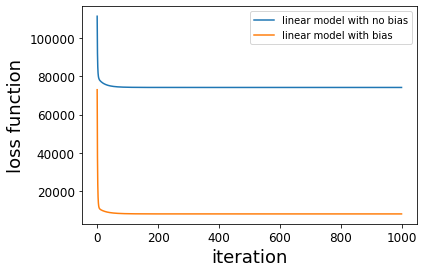

In [8]:
nb_of_iterations = 1000
step_size = 1e-5
ridge_parameter = 0.2

iteration_bias, loss_function_array_bias = gradient_descent(A_train, Y_train, nb_of_iterations, step_size, ridge_parameter, add_bias = True)
iteration, loss_function_array = gradient_descent(A_train, Y_train, nb_of_iterations, step_size, ridge_parameter, add_bias = False)

plt.plot(iteration, loss_function_array, label='linear model with no bias')   
plt.plot(iteration_bias, loss_function_array_bias, label='linear model with bias')   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.legend()
plt.show()


From previous results, we can conclude that adding a bias allows to reach more accuracy (the loss is closer to 0), that seems reasonabale as it is equivalent to adding a constant (and turn a linear function in a affine function). Still for sake of simplicity we will stick to the linear model as our main goal in this project is to understand various optimization methods.
Besides, it's worth noticed that the linear model underfits data because the loss doesn't seem to converge towards 0. Indeed, in the train dataset we have 15,000 rows which means the average squared error is 74/15 $\approx$ 5. On the whole dataset, we make an error of $\sqrt(5) \approx 2,23 $ that is to say 223,000 $ per house which is huge for the prices in dataset (not prices of today housing market).

For a step size too high (in our case 1e-3 for instance), the GD method diverges towards infinity.

Below, we provide convergence rate for various step sizes.

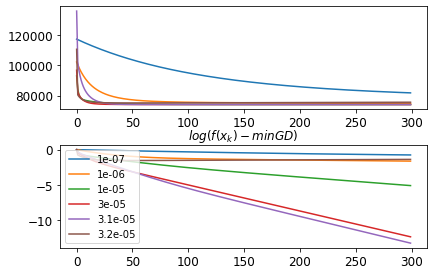

In [14]:
niter = 300
ridge_parameter = 0.2
plot_convergence_rate(A_train,Y_train, niter, ridge_parameter)


The empirical optimal step size seems to be around $3.1 \times 10^{-5}$.
It's worthy noticed that after a couple hundred iterations the linear model isn't able to decrease more than 80,000 which is an indicator of underfitting.

### Question 3: What is the optimal step choice ? How does this compare with the theory ?

The theoretical optimal step size is identical to the one we find through experimentations.

In [15]:
C = A_train.T.dot(A_train)
step_size_optimal = 1/(np.linalg.norm(C,2) + np.linalg.norm(C,-2)) # we use a power 2 to get the eigenvalue and not the singular value
print(f"The optimal step size is {step_size_optimal}")

The optimal step size is 3.129270961674127e-05


### Question 4: Show the regression performance on the test set as the ridge penalty changes. 

we keep the same step size, and we will just modify the ridge parameter.

The behaviour of E is strange with regards to $\lambda$. 
In my opinion this is because of underfitting, indeed we see that at $\lambda = 0$ we have a huge test error, which is a sign of underfitting. Actually we don't really need to add a ridge term in that case, expect for ensuring strong convexity, because there is no overfitting so no need for regularization.
The fact that the error decreases with  $\lambda$ suggests it is better to optimize on the ridge term, which will ensure X goes towards 0, which may be seen as peculiar. The "bump" is a sign of the competition in optimizing the data-fitting term and the ridge term.

Besides, this may also be a consequence of the capping of $y$ . Indeed, in the dataset all houses' prices above 5 have been cut to 5 (that makes the behavior of linear model unlikely to capture the complexity of data).

Ridge: 2.2917193432011222
Optimal X is :
[ 0.42542188  0.0931407   0.0435047  -0.03089883 -0.00388537 -0.02246469
 -0.11305212 -0.07612887]


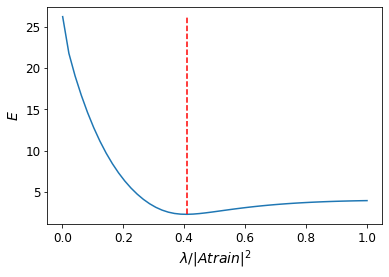

In [98]:
start = 1e-3
stop = 1
num = 50

plot_evolution_on_test_error(A_train, Y_train, A_test, Y_test, start, stop, num)

Ridge: 1.70318759721485
Optimal X is :
[ 0.03723891  0.00592218  0.00817616 -0.00306841 -0.00130585 -0.00149642
 -0.00787803 -0.00271699]


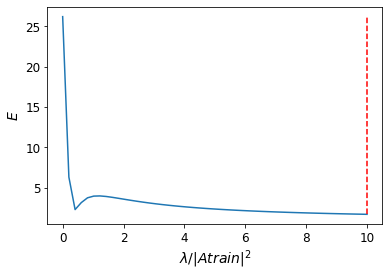

In [99]:
start = 1e-3
stop = 10
num = 50
plot_evolution_on_test_error(A_train, Y_train, A_test, Y_test, start, stop, num)

### Appendix: results on a toy dataset

Here, for sake of comparison, we test our implementation on GD on a toy dataset with 200 samples and 2 features, where a linear relation is sufficient to capture the complexity of data. 
We wee that GD converges towards 0 (no overfitting), and that adding regularization only worsens the performance of the mode as the linear relation is already sufficient to capture the data (it only deviates the model from its task.)

In [16]:
nsamples = 200
sigma = 0.4
xtrain, ytrain = generate_dataset(nsamples, sigma)
xtest, ytest = generate_dataset(nsamples, sigma)

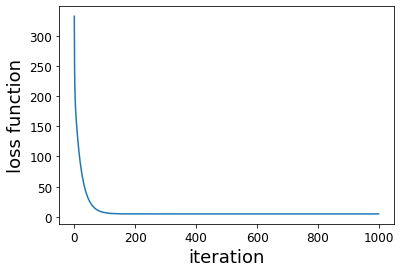

In [19]:
nb_of_iterations = 1000
step_size = 1e-3
ridge_parameter = 0.2

iteration, loss_function_array = gradient_descent(xtrain, ytrain, nb_of_iterations, step_size, ridge_parameter, add_bias = True)
plt.plot(iteration, loss_function_array)   
plt.xlabel("iteration", rotation=0, fontsize=18)
plt.ylabel("loss function", rotation=90, fontsize=18)
plt.show()


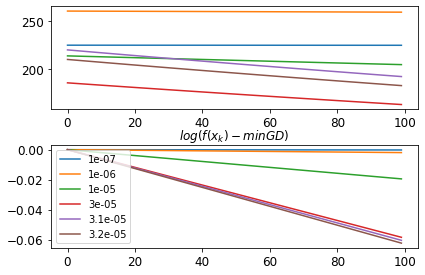

In [20]:
niter = 100
ridge_parameter = 0.2
plot_convergence_rate(xtrain, ytrain, niter, ridge_parameter)

Ridge: 0.0010197440579736018
Optimal X is :
[3.99593373 2.99692539]


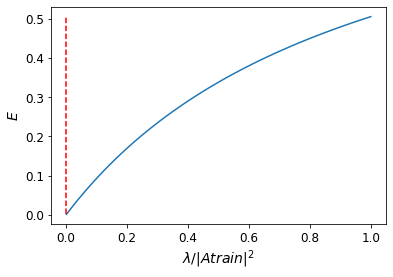

In [21]:
start = 1e-3
stop = 1
num = 50

plot_evolution_on_test_error(xtrain, ytrain, xtest, ytest, start, stop, num)